<a href="https://colab.research.google.com/github/fajar586-arch/Thesis/blob/main/baws_DNN_15_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original shape: (29298, 55)
After VarianceThreshold: (23438, 39)
After Mutual Information: (23438, 39)
Epoch 1/60
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.4188 - loss: 1.1488 - val_accuracy: 0.4855 - val_loss: 1.0137
Epoch 2/60
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4647 - loss: 1.0414 - val_accuracy: 0.5132 - val_loss: 0.9844
Epoch 3/60
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4857 - loss: 1.0002 - val_accuracy: 0.5166 - val_loss: 0.9686
Epoch 4/60
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5108 - loss: 0.9782 - val_accuracy: 0.5288 - val_loss: 0.9588
Epoch 5/60
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5160 - loss: 0.9602 - val_accuracy: 0.5205 - val_loss: 0.9530
Epoch 6/60
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5231 - loss: 0.9515 - val_accuracy: 0.5282 - val_loss: 0.9492
Epoch 7/60
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5268 - loss: 0.9454 - val_accuracy: 0.5382 - val_loss: 0.9445


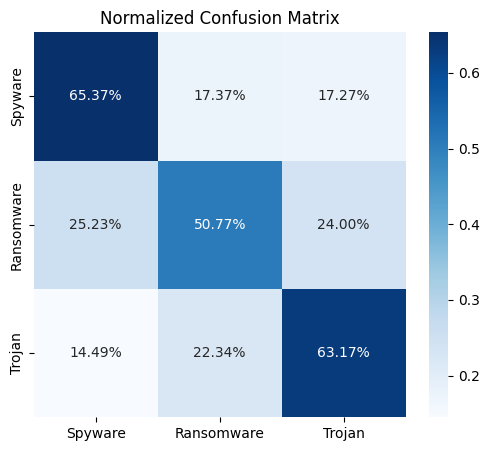

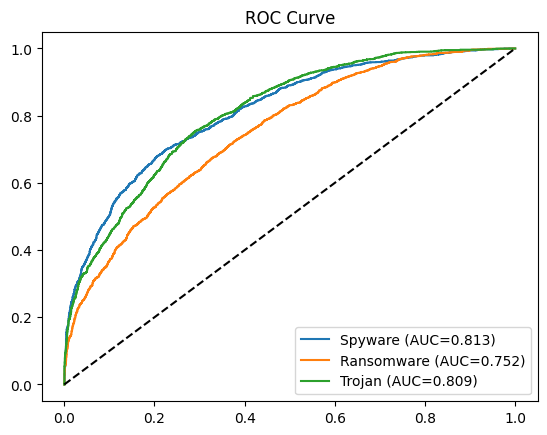

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# ==========================================================
# IMPORT LIBRARIES
# ==========================================================
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as mt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
tf.random.set_seed(42)

# ==========================================================
# LOAD DATA
# ==========================================================
data = pd.read_csv("/content/Obfuscated-MalMem2022.csv")

data = data[data["Class"] != "Benign"]
data = data.drop(columns=["Class"])

def classifyCategories(s):
    if s.startswith("Spyware"):
        return 0
    elif s.startswith("Ransomware"):
        return 1
    else:
        return 2

data["Category"] = data["Category"].apply(classifyCategories)

y = data["Category"].values
X = data.drop(columns=["Category"]).values

print("Original shape:", X.shape)

# ==========================================================
# SPLIT
# ==========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# ==========================================================
# FEATURE ENGINEERING
# ==========================================================

# 1️⃣ Remove low variance features
var_filter = VarianceThreshold(threshold=0.01)
X_train = var_filter.fit_transform(X_train)
X_test = var_filter.transform(X_test)

print("After VarianceThreshold:", X_train.shape)

# 2️⃣ Mutual Information Feature Selection
selector = SelectKBest(
    score_func=mutual_info_classif,
    k=min(300, X_train.shape[1])  # keep top 300 features
)

X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

print("After Mutual Information:", X_train.shape)

# 3️⃣ Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ==========================================================
# CLASS WEIGHTS (Important)
# ==========================================================
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# ==========================================================
# BUILD SAME STYLE DNN (Research Comparable)
# ==========================================================
def build_model(input_dim, num_classes):

    model = keras.Sequential()

    model.add(keras.layers.Dense(256, input_shape=(input_dim,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(128))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(64))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

model = build_model(X_train.shape[1], 3)

# ==========================================================
# CALLBACKS
# ==========================================================
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True
)

# ==========================================================
# TRAIN
# ==========================================================
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=60,
    batch_size=128,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)

# ==========================================================
# EVALUATION
# ==========================================================
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\nClassification Report:\n")
print(mt.classification_report(y_test, y_pred))

accuracy = mt.accuracy_score(y_test, y_pred)
print("Final Accuracy:", accuracy)

# ==========================================================
# ==========================================================
# NORMALIZED CONFUSION MATRIX
# ==========================================================
labels = ["Spyware","Ransomware","Trojan"]

cm = mt.confusion_matrix(y_test, y_pred)

# Normalize (row-wise)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
sns.heatmap(cm_normalized,
            annot=True,
            fmt=".2%",
            xticklabels=labels,
            yticklabels=labels,
            cmap="Blues")

plt.title("Normalized Confusion Matrix")

plt.savefig("confusion_matrix.pdf", format="pdf", bbox_inches="tight")
plt.show()

# ==========================================================
# ROC CURVE
# ==========================================================
y_test_cat = to_categorical(y_test, 3)

plt.figure()
for i in range(3):
    fpr, tpr, _ = mt.roc_curve(y_test_cat[:, i], y_pred_prob[:, i])
    auc = mt.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{labels[i]} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("ROC Curve")
plt.savefig("roc_curve.pdf", format="pdf", bbox_inches="tight")
plt.show()

from google.colab import files
files.download("roc_curve.pdf")
files.download("confusion_matrix.pdf")